Wellbore Performance (TPR)
**Objective:** Calculate the Tubing Performance Relationship (TPR) curve.
**Author:** Ade Anggi Naluriawan Santoso

While the IPR represents what the reservoir *can deliver*, the TPR represents what the wellbore *requires* to produce a given flow rate. The TPR curve plots the required Flowing Bottomhole Pressure ($P_{wf}$) vs. Flow Rate ($q$).

**The Pressure Drop Equation:**
The total pressure drop in a vertical well is the sum of three components:
1.  **Elevation (Hydrostatic) Component:** The weight of the fluid column (usually 80-95% of the total drop).
2.  **Friction Component:** Drag against the pipe walls.
3.  **Acceleration Component:** Kinetic energy change (usually negligible).

$$\frac{dP}{dL} = \frac{dP}{dL}_{elev} + \frac{dP}{dL}_{fric} + \frac{dP}{dL}_{acc}$$

In this notebook, we will implement a **"Marching Algorithm"** (Step-wise Integration) to calculate $P_{wf}$ starting from a known Wellhead Pressure ($P_{wh}$).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

# --- SIMPLIFIED FLUID PROPERTY HELPERS (Condensed from Ch. 2) ---
# We need these to calculate density at different depths/pressures
def calc_z(P, T):
    # Simplified correlation for Z-factor (constant for demo)
    # In a real app, import the full DAK function
    return 0.9 

def calc_bo(P):
    # Simplified linear Bo (bbl/stb)
    return 1.2 - 0.00005 * P

def calc_rs(P):
    # Simplified Rs (scf/stb) - capped at bubble point
    return min(P * 0.2, 800)

## 1. Defining the Multiphase Flow Model
To calculate pressure drop, we need the **Mixture Density** ($\rho_m$) and **Friction Factor** ($f$).

We will use a simplified homogeneous model similar to **Poettmann-Carpenter**:
1.  Calculate In-situ Volume of Oil and Gas at specific P & T.
2.  Calculate Mixture Density.
3.  Calculate Velocity and Friction.

**Note:** In professional software (and the book), complex correlations like **Hagedorn-Brown** or **Beggs-Brill** are used to account for "holdup" (slippage between gas and liquid).

In [2]:
def calc_pressure_gradient(P, T, q_oil, d_tubing_in, wor, glr, gas_grav, oil_grav):
    """
    Calculates the pressure gradient (psi/ft) at a specific point in the tubing.
    """
    # 1. CONSTANTS
    d_ft = d_tubing_in / 12.0
    area = np.pi * (d_ft/2)**2
    
    # 2. FLUID PROPERTIES AT P & T
    # Water properties
    Bw = 1.05 # bbl/stb (constant for simplicity)
    rho_w = 62.4 # lb/ft3
    
    # Oil properties
    Bo = calc_bo(P)
    Rs = calc_rs(P)
    rho_o = 62.4 * oil_grav # approx density
    
    # Gas properties
    z = calc_z(P, T)
    T_R = T + 460
    Bg = 0.02827 * z * T_R / P # res cubic ft / scf
    rho_g = 2.7 * gas_grav * P / (z * T_R)
    
    # 3. VOLUMETRIC RATES (In-situ)
    # q_liquid = q_oil + q_water
    q_w = q_oil * wor
    
    # Gas in pipe = Total Gas - Dissolved Gas
    # Total Gas = q_oil * GLR
    # Dissolved Gas = q_oil * Rs
    q_g_free_scf = max(0, q_oil * (glr - Rs))
    
    # Convert to actual cubic feet per second (ft3/s)
    # 1 day = 86400 sec, 1 bbl = 5.615 ft3
    q_o_in_situ = (q_oil * Bo * 5.615) / 86400
    q_w_in_situ = (q_w * Bw * 5.615) / 86400
    q_g_in_situ = (q_g_free_scf * Bg) / 86400
    
    q_total_mix = q_o_in_situ + q_w_in_situ + q_g_in_situ
    
    # 4. MIXTURE DENSITY (Holdup neglected for this simple model)
    # Mass flow rate (lb/s)
    mass_o = (q_oil * 5.615 / 86400) * rho_o
    mass_w = (q_w * 5.615 / 86400) * rho_w
    mass_g = (q_oil * glr / 86400) * 0.0765 * gas_grav # approx gas mass
    
    mass_total = mass_o + mass_w + mass_g
    rho_mix = mass_total / q_total_mix
    
    # 5. VELOCITY & FRICTION
    v_mix = q_total_mix / area
    
    # Reynolds Number (Simplified viscosity assumption 10 cp)
    # Re = 1488 * rho * v * D / mu
    mu_mix = 10.0 # cp
    N_re = 1488 * rho_mix * v_mix * d_ft / mu_mix
    
    # Friction Factor (Chen's equation approximation or smooth pipe)
    # Simple Moody friction for turbulent flow
    if N_re > 0:
        f = 0.005 # Typical range for old pipe
    else:
        f = 0
        
    # 6. GRADIENT CALCULATION
    # Elevation Gradient
    dp_dl_elev = rho_mix / 144.0 # Convert lb/ft3 to psi/ft
    
    # Friction Gradient
    # dP_f = (2 * f * rho * v^2) / (gc * D)
    # gc = 32.174
    dp_dl_fric = (2 * f * rho_mix * v_mix**2) / (32.174 * d_ft * 144)
    
    # Total Gradient (psi/ft)
    return dp_dl_elev + dp_dl_fric

## 2. The Marching Algorithm (Top-Down)
We cannot just use one density for the whole well because gas expands as it rises, changing the density significantly.

We divide the well into small segments (e.g., 50 segments).
1. Start at Surface ($P = P_{wh}$, Depth = 0).
2. Calculate Gradient ($dP/dL$) at current conditions.
3. Calculate Pressure at next depth step: $P_{new} = P_{old} + (dP/dL \times \Delta L)$.
4. Repeat until Bottomhole Depth is reached.

In [3]:
def calc_pwf_marching(q_oil, p_wh, depth, steps=50):
    """
    Calculates Bottomhole Pressure (Pwf) given a surface pressure (Pwh)
    using a stepping algorithm.
    """
    # Well / Fluid Constants for this exercise
    T_avg = 150 # deg F
    d_tubing = 2.441 # inches (2-7/8 tubing)
    wor = 0.5 # Water Oil Ratio
    glr = 800 # Gas Liquid Ratio (scf/stb)
    gas_grav = 0.7
    oil_grav = 0.85
    
    # Step size
    delta_h = depth / steps
    
    current_p = p_wh
    current_depth = 0
    
    for i in range(steps):
        # Calculate Gradient at current P, T
        grad = calc_pressure_gradient(current_p, T_avg, q_oil, d_tubing, wor, glr, gas_grav, oil_grav)
        
        # Increment Pressure
        # P_bottom = P_top + Grad * Height
        current_p += grad * delta_h
        current_depth += delta_h
        
    return current_p

## 3. Generating the TPR Curve
Now we run the marching algorithm for a range of flow rates to generate the **Tubing Performance Relationship (TPR)**.

* **Low Rates:** High slippage, liquid fallback (though our simplified model assumes homogeneous flow, you will still see high gravity effects).
* **High Rates:** High friction dominance.

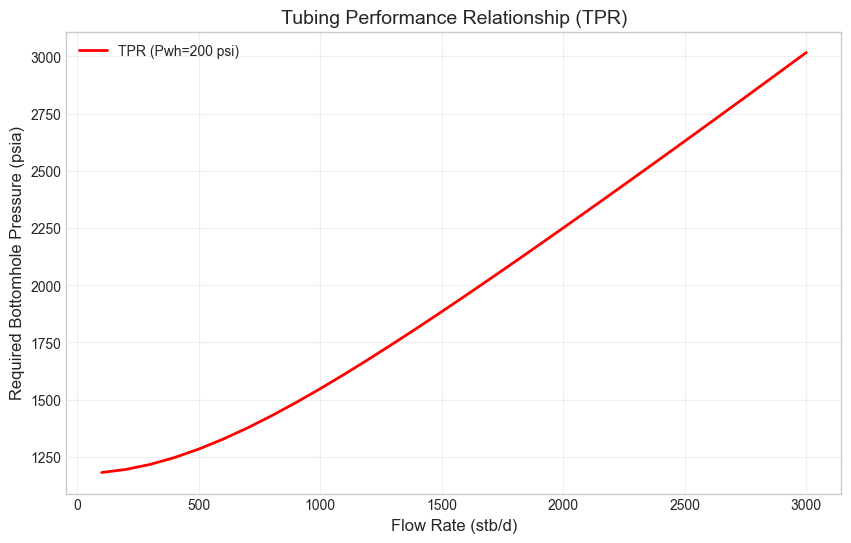

In [4]:
# --- INPUTS ---
p_wh = 200      # Wellhead Pressure (psia)
well_depth = 8000 # ft
rates = np.linspace(100, 3000, 30) # 100 to 3000 stb/d

# Calculate Pwf for each rate
pwf_values = []
for q in rates:
    pwf = calc_pwf_marching(q, p_wh, well_depth)
    pwf_values.append(pwf)

# --- PLOTTING ---
plt.figure(figsize=(10, 6))

plt.plot(rates, pwf_values, label=f'TPR (Pwh={p_wh} psi)', color='red', linewidth=2)

plt.title(f"Tubing Performance Relationship (TPR)", fontsize=14)
plt.xlabel("Flow Rate (stb/d)", fontsize=12)
plt.ylabel("Required Bottomhole Pressure (psia)", fontsize=12)

# TPR curves curve UPWARDS (Higher rate = Higher friction = More pressure required to lift)
# But wait? Why do some TPR curves go down then up? 
# That is due to liquid loading/slippage at low rates. 
# Our homogeneous model will mostly show the friction effect (curving up).

plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 4. Nodal Analysis: Finding the Operating Point
To find the actual production rate of the well, we overlay the **IPR** (from Chapter 3) and this **TPR**. The intersection is the solution.

Let's define a simple IPR function and plot both.

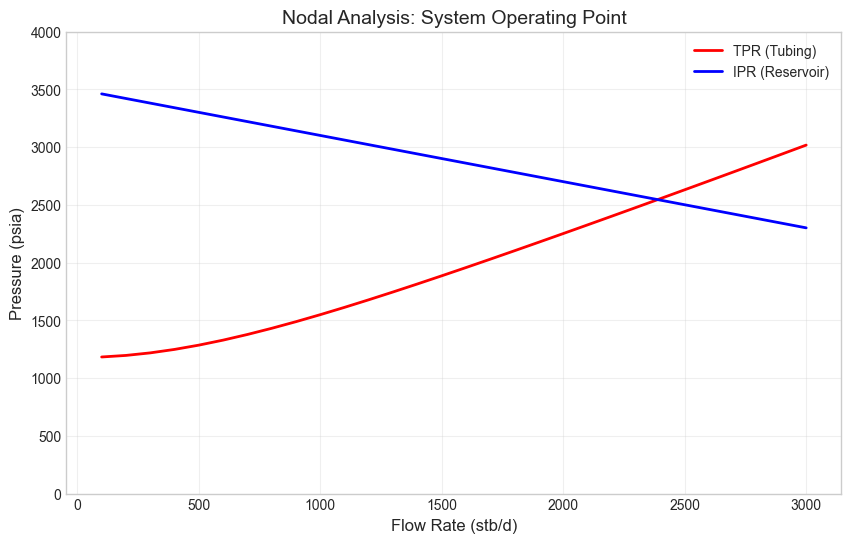

In [5]:
# Define a simple IPR for intersection
def simple_ipr(q, p_res, pi):
    # Straight line IPR (P_wf = P_res - q/PI)
    return p_res - (q / pi)

# IPR Parameters
p_reservoir = 3500 # psia
pi_index = 2.5 # stb/d/psi

# Calculate IPR Pwf values for the same rates
ipr_values = [simple_ipr(q, p_reservoir, pi_index) for q in rates]

# Plot Intersection
plt.figure(figsize=(10, 6))

plt.plot(rates, pwf_values, label='TPR (Tubing)', color='red', linewidth=2)
plt.plot(rates, ipr_values, label='IPR (Reservoir)', color='blue', linewidth=2)

# Find approximate intersection (visually)
plt.title(f"Nodal Analysis: System Operating Point", fontsize=14)
plt.xlabel("Flow Rate (stb/d)", fontsize=12)
plt.ylabel("Pressure (psia)", fontsize=12)
plt.ylim(0, 4000)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()